# EDA Near Ecosystem

## Set-up

In [1]:
# Configs 
import pandas as pd 
import numpy as np 

from os import getcwd
from os.path import join 

import xlrd

In [2]:
# load file 

## path
file = "Consolidated_Sputnik_DAO_Proposals.xlsx"
path = join(getcwd(), file)

## load 
df1 = pd.read_excel(path) #probaly not best practice if file is large... 

In [3]:
## load sputnik dao stats
file2 = 'Sputnik DAO Stats.xlsx'
path2 = join(getcwd(), file2)
df2 = pd.read_excel(path2, index_col=None, na_values=['NA'], usecols = "A:H")

## Pre-processing

To-do: 
- dao addresses written differently 


In [4]:
# Rename columns
df1 = df1.rename( columns={"Unnamed: 0" : "DAO Proposal ID"})

In [5]:
# columns header lower case
df1.columns = df1.columns.str.lower()

In [6]:
#fix amount (near) colum  

#P1: Values have been replace x & NaN- A: replace x, NaN with 0
df1['amount (near)'] = df1['amount (near)'].replace(["x", np.nan], 0)


In [7]:
#standardise description column
df1['description'] = df1['description'].str.replace(r'[^a-zA-Z]+', ' ', regex = True).str.lower().str.strip() #.str.split()
## Applys 1. keeps only alphabetic letters, lowercase everything, strips spaces at end, split words


# filtering of key words (see below for retional)
df1['description'] = df1['description'].replace({'near':'', 'org':'', 'https':'', 'gov': ''}, regex = True)

#Note: Rational against removing hyperlinks - Many of the words link to topic relevant
#forum discussion providing additional context. Keeping them in hope of more info, however
# repeating key words in hyperlink 

In [8]:
# filter characters of one letter 

## define function filter 
def letter_length_filter(sentence):
    
    new_text = ""
    
    for word in sentence.split(): 
        
        if len(word) > 3: 
            
            new_text = new_text + " " + word
        
    return new_text


## apply function 
df1['description'] = df1['description'].apply(lambda x: letter_length_filter(x).strip() )

In [9]:
#lemmitisation 
#def.: Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item.

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()

def lemma(sentence):
    
    new_text = ""
    
    for word in sentence.split(): 
                
        word = lemmatizer.lemmatize(word, pos='v')
                    
        new_text = new_text + " " + word
        
    return new_text

df1['description'] = df1['description'].apply(lambda x: lemma(x).strip() )


In [10]:
df1['description'] = df1['description'].str.split()

In [11]:
### Network analysis prep
### Replace dao column with address
df1['dao'].unique()

address = ['communitysquad.sputnikdao.near',
           'creatives.sputnikdao.near',
           'grants.sputnikdao.near',
           'marketing-vertical.sputnikdao.near',
           'humanguild.sputnikdao.near',
           'sandbox.sputnikdao.near', #unsure
           'knightsofgondor.sputnikdao.near', #unidentified
           'degens.sputnikdao.near',
           'assemblyscript.sputnikdao.near',
           'genesis.sputnikdao.near',
           'move.sputnikdao.near',
           'nxm-dao.sputnikdao.near', 
           'bounties.sputnikdao.near',#unsure
           'createbase.sputnikdao.near']
           
           
replace = dict(zip(df1['dao'].unique(), address))

#df1[ (df1.dao =='Bounties') & (df1.target.str.contains(".sputnikdao.near")) ] 


In [12]:
## replace dao name with address 

df1['dao'] = df1['dao'].replace(replace)

## Rudamentary analysis 

#### Proposer

In [13]:
print(f"""Unique Proposer: {len(df1['proposer'].unique())}""")

Unique Proposer: 595


In [14]:
proposed_value = {}
for name in df1['proposer'].unique(): 
    proposed_value[name] = df1['amount (near)'][(df1.proposer == name) & (df1.status == 'Success')].sum()

In [15]:
df_proposed_value = pd.DataFrame.from_dict( proposed_value, orient='index', columns=['Value in Near'] ) 
df_pv_sort = df_proposed_value.sort_values(by ='Value in Near', ascending=False)

In [16]:
import plotly.express as px
fig = px.scatter(df_pv_sort, y="Value in Near",
                 labels={
                     "index": "Unique Proposer"
                 },
                 title='Unique Proposer vs. Value in Near')
fig.show()

#### Target

In [17]:
print(f"""Unique Proposer: {len(df1['target'].unique())}""")

Unique Proposer: 702


In [18]:
target_value = {}
for name in df1['target'].unique(): 
    target_value[name] = df1['amount (near)'][(df1.target == name) & (df1.status == 'Success')].sum()

In [19]:
df_target_value = pd.DataFrame.from_dict( target_value, orient='index', columns=['Value in Near'] ) 
df_tv_sort = df_target_value.sort_values(by ='Value in Near', ascending=False)

In [20]:
import plotly.express as px
fig = px.scatter(df_tv_sort, y="Value in Near",
                 labels={
                     "index": "Unique target"
                 },
                 title='Unique Target vs. Value in Near')
fig.show()

### Proposal description

In [21]:
## Set-up
import matplotlib.pyplot as plt
from collections import Counter

df1['description'][df1['dao']=='Community Squad']

Series([], Name: description, dtype: object)

In [22]:
def plot_top_n_words(dao, n_words): 
    """
    Purpose: Plot to n words as bar chart for a given dao
    Variables: 
        - dao = organisation to be analysed
        - n_words = number of top words    
    """
    
    ### make list to count 
    words = sum(df1['description'][df1['dao']==dao].tolist(), [])
    
    ###  count words 
    word_counts = Counter(words)
    
    ### make dict & sort
    word_counts_sorted = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
    
   
    ### select top words 
    top_words = list(word_counts_sorted.keys())[:n_words]
    top_word_counts = list(word_counts_sorted.values())[:n_words]
    
    ### Bar plot 
    fig = plt.figure(figsize = (20, 8)) 
    plt.bar(top_words, top_word_counts, color ='green',
            width = 0.5)
    plt.xlabel("Words")
    plt.xticks(rotation=45)
    plt.ylabel("No. of word occured")
    plt.title("Word frequency")
    plt.show()

## 1. Most common words in proposal descripton

In [23]:
all_words = sum(df1['description'].tolist(), [])

In [24]:
word_counts = Counter(all_words)
word_counts_sorted = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

In [25]:
df_word_counts = pd.DataFrame.from_dict(word_counts_sorted, orient='index', columns=['count'])
df_word_counts.head(25)

count
reward        620
claim         582
sandbox       550
mintbase      299
september     270
october       248
approve       244
bounty        240
august        239
payout        233
store         225
guild         188
community     175
council       162
proposal      162
create        157
july          144
mint          142
request       138
fund          136
creation      131
createbase    107
june          107
onboarding    105
month         104

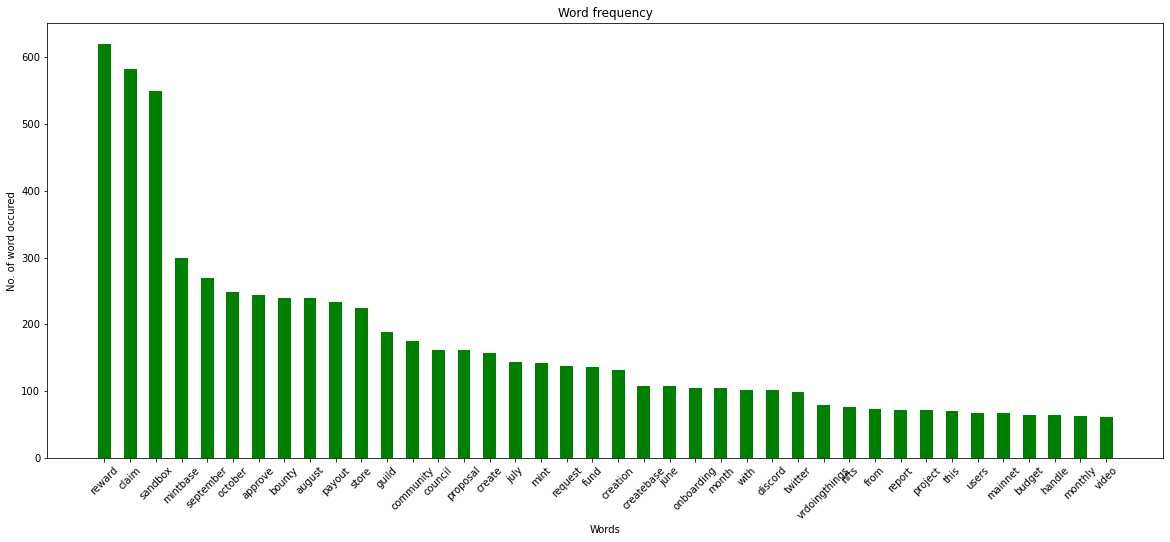

In [26]:
import matplotlib.pyplot as plt

# Dataset generation
n=40
top_words = list(word_counts_sorted.keys())[:n]
top_word_counts = list(word_counts_sorted.values())[:n]
fig = plt.figure(figsize = (20, 8))

#  Bar plot
plt.bar(top_words, top_word_counts, color ='green',
        width = 0.5)
plt.xlabel("Words")
plt.xticks(rotation=45)
plt.ylabel("No. of word occured")
plt.title("Word frequency")
plt.show()

#### Individual DAOs

#### communitysquad.sputnikdao.near ####
Proposals: 175


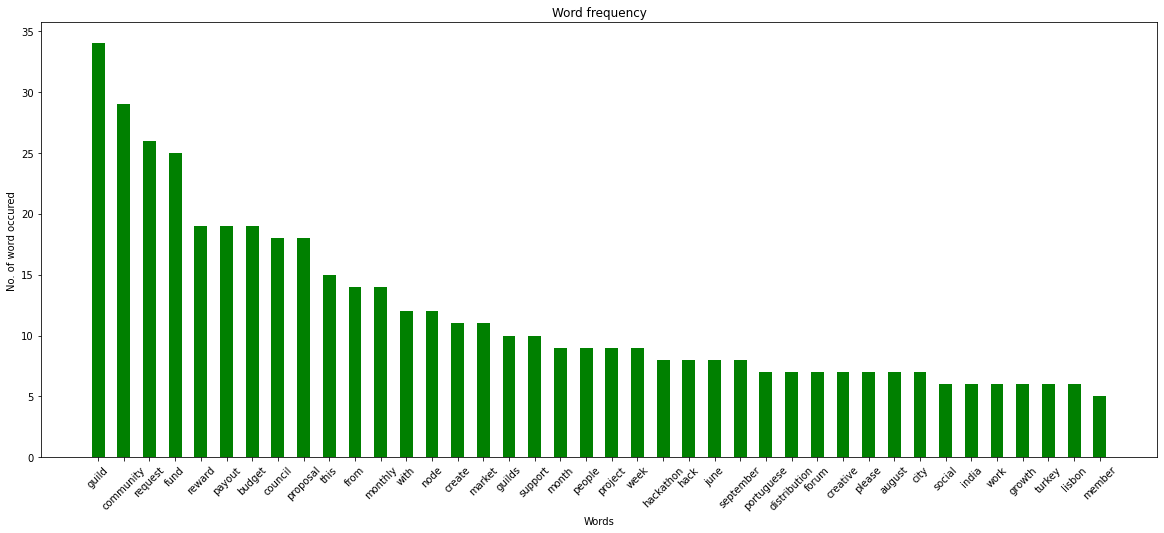

#### creatives.sputnikdao.near ####
Proposals: 82


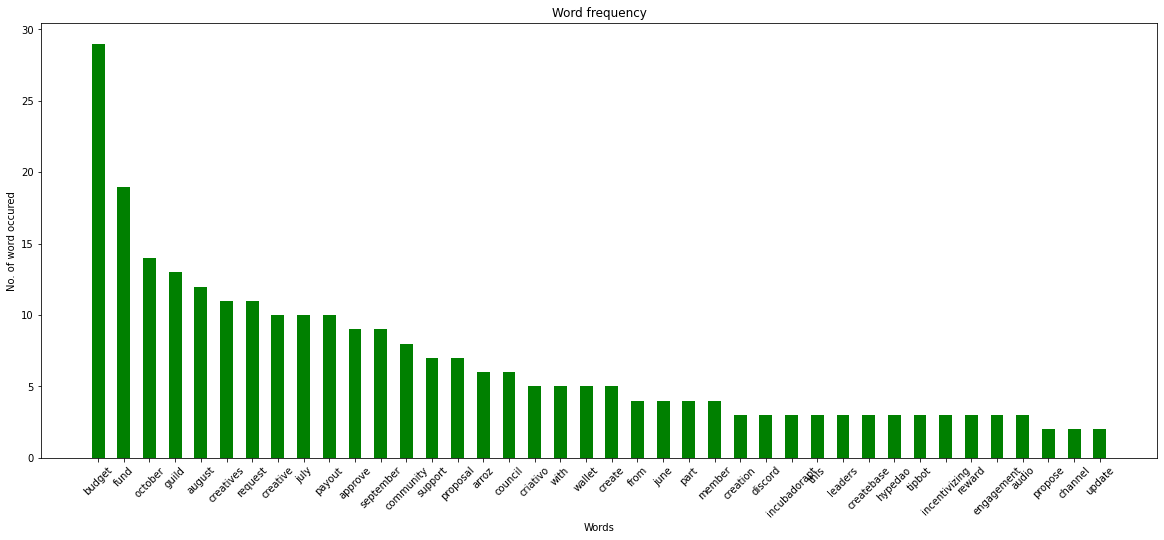

#### grants.sputnikdao.near ####
Proposals: 10


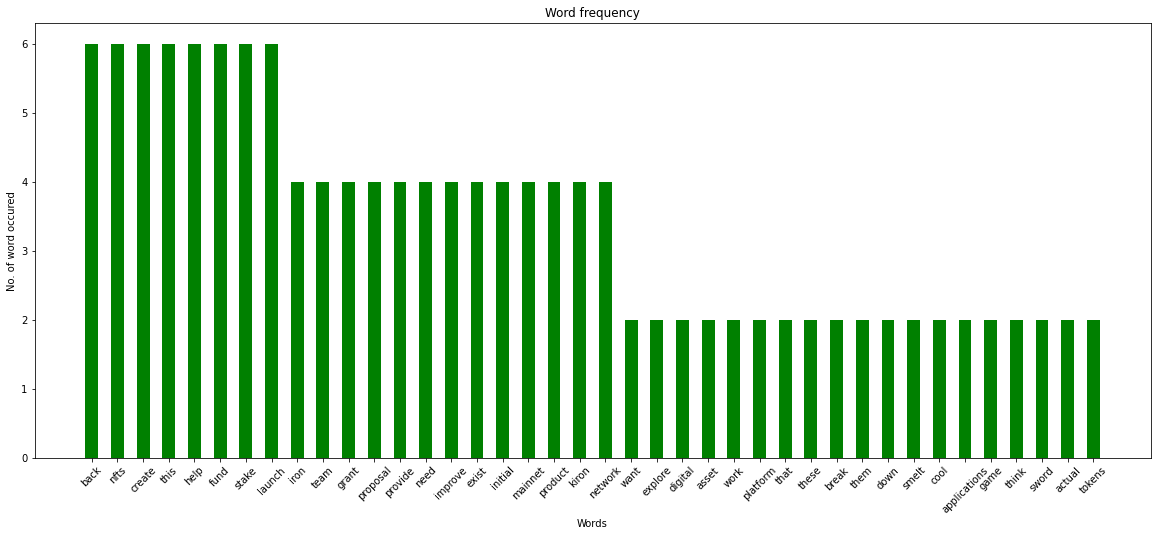

#### marketing-vertical.sputnikdao.near ####
Proposals: 71


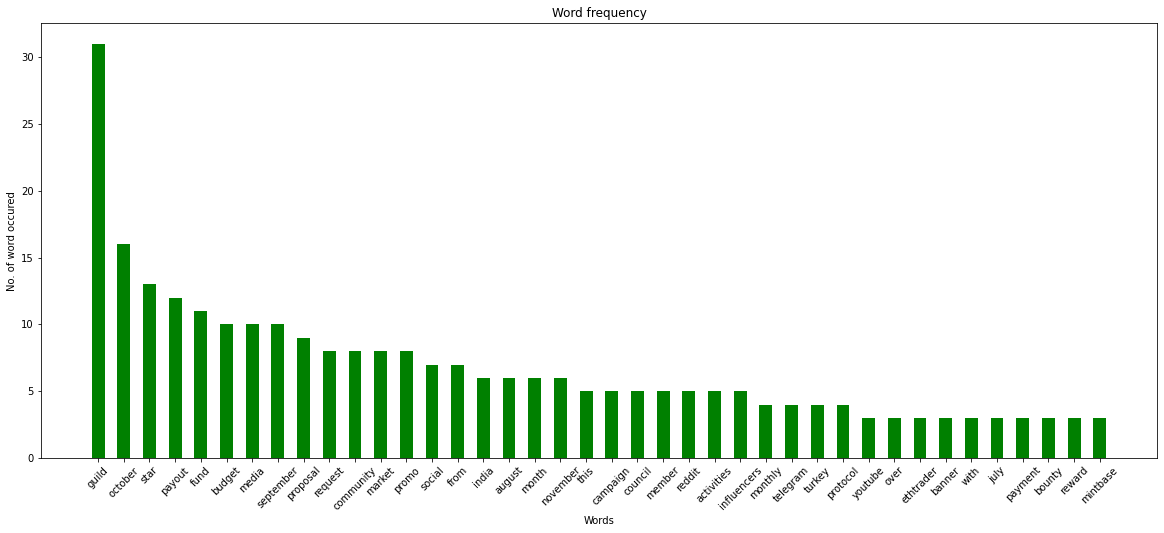

#### humanguild.sputnikdao.near ####
Proposals: 65


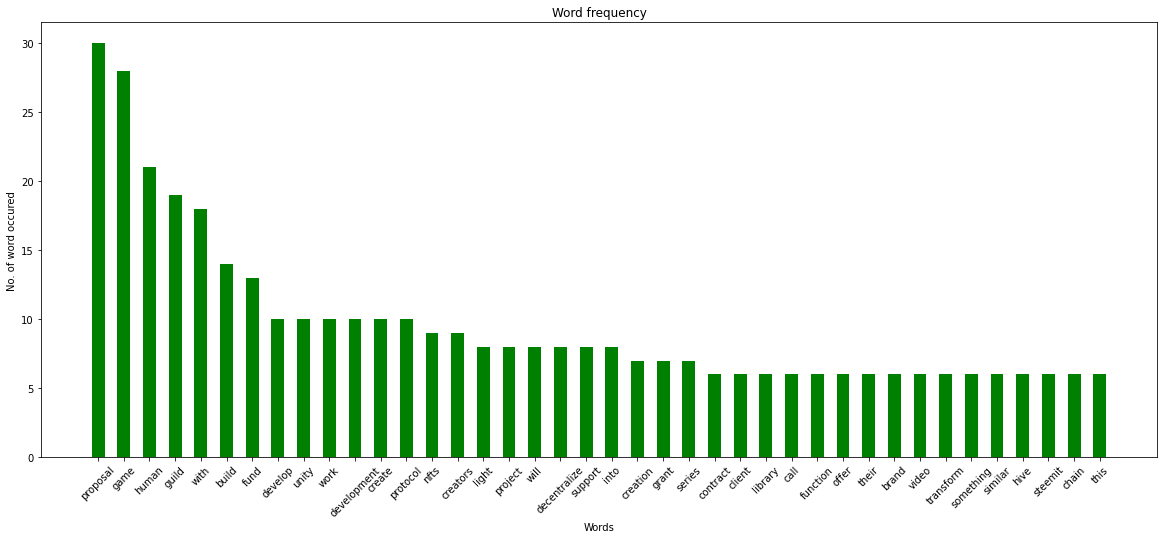

#### sandbox.sputnikdao.near ####
Proposals: 455


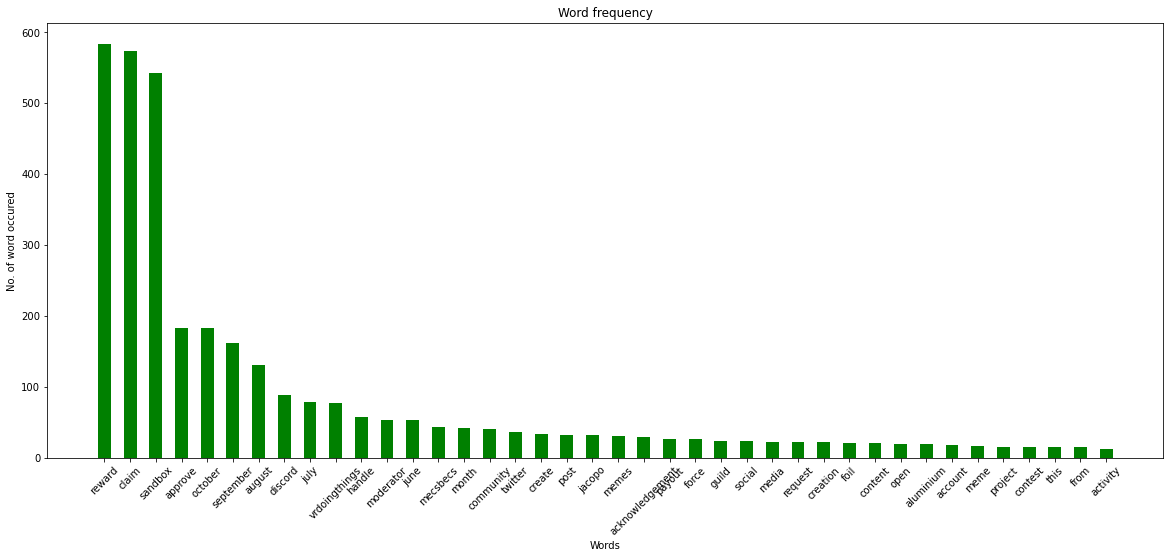

#### knightsofgondor.sputnikdao.near ####
Proposals: 46


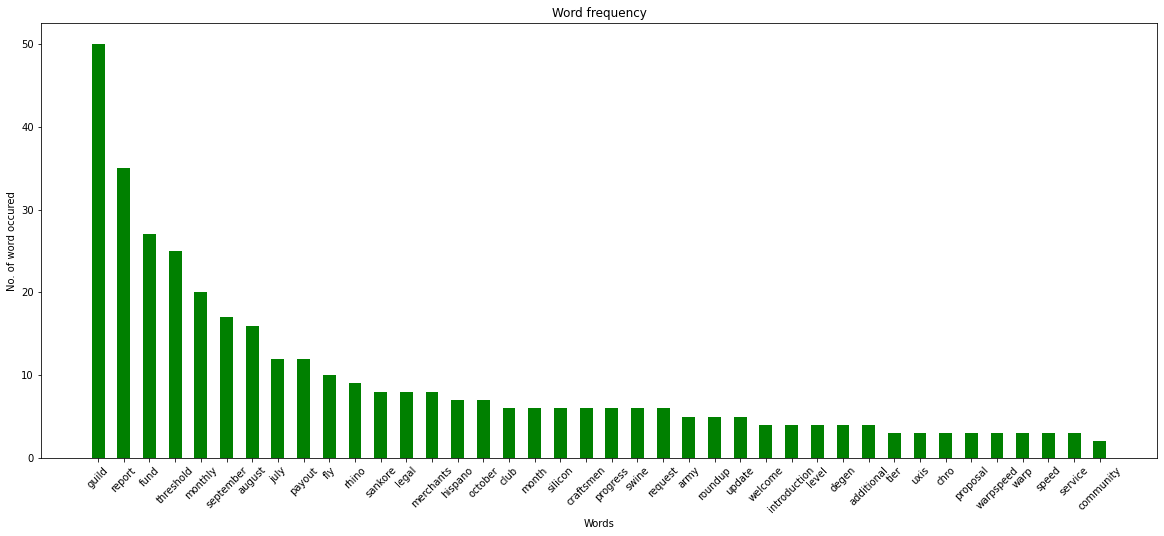

#### degens.sputnikdao.near ####
Proposals: 97


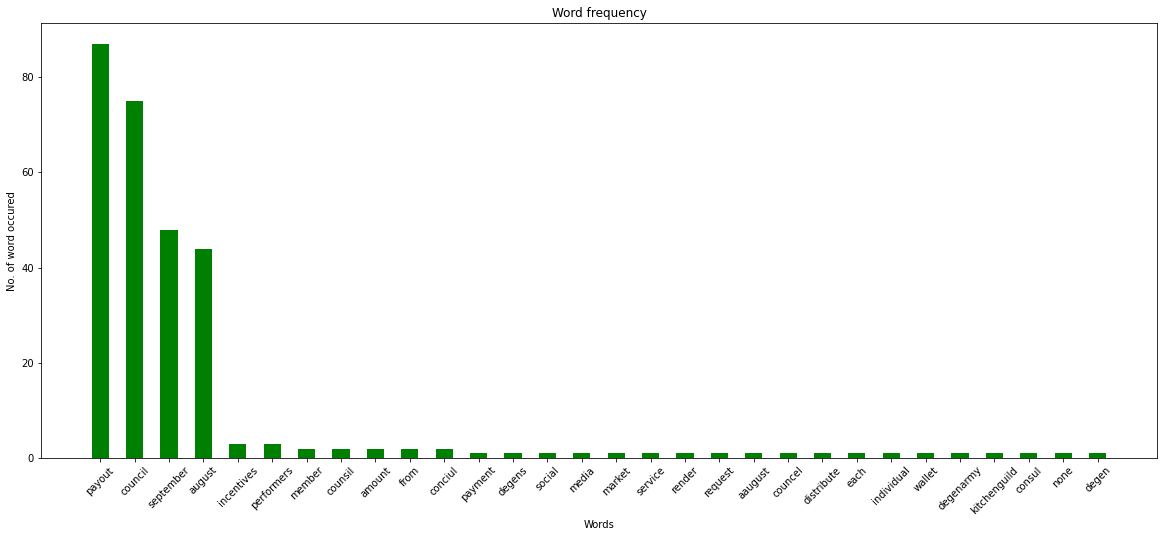

#### assemblyscript.sputnikdao.near ####
Proposals: 21


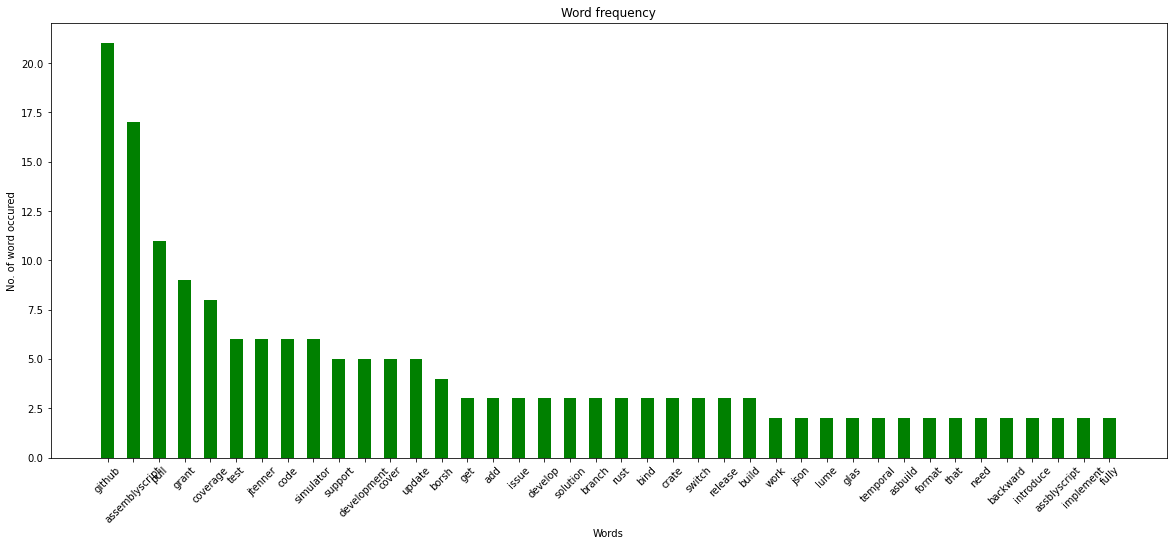

#### genesis.sputnikdao.near ####
Proposals: 45


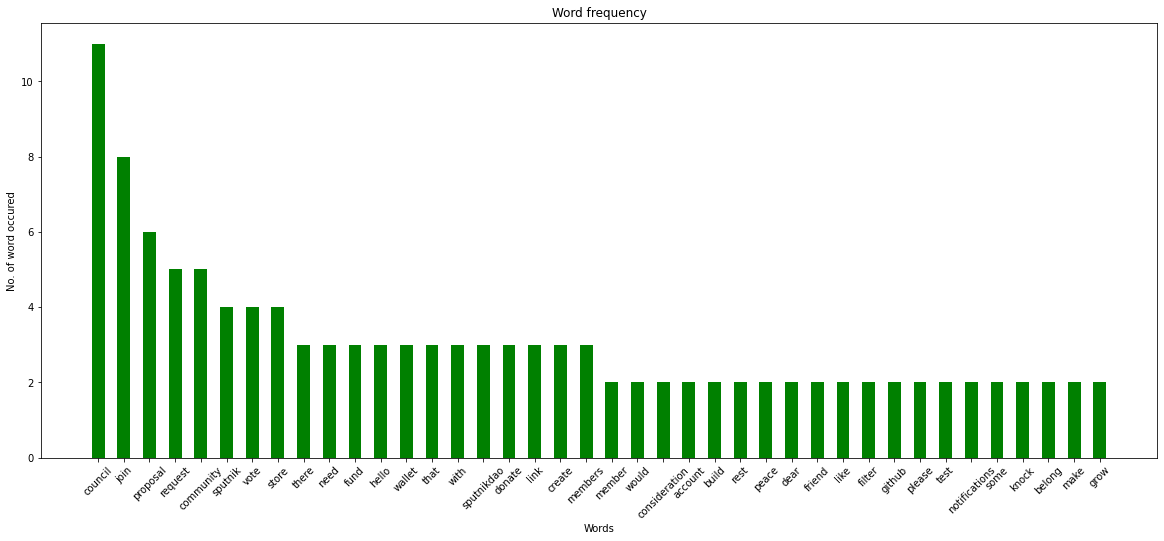

#### move.sputnikdao.near ####
Proposals: 10


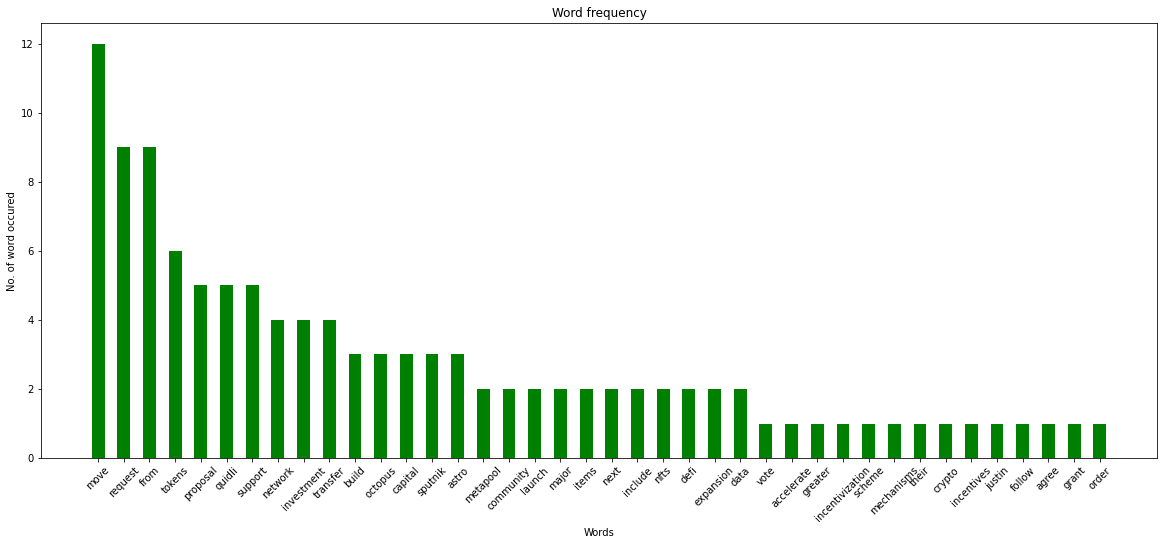

#### nxm-dao.sputnikdao.near ####
Proposals: 106


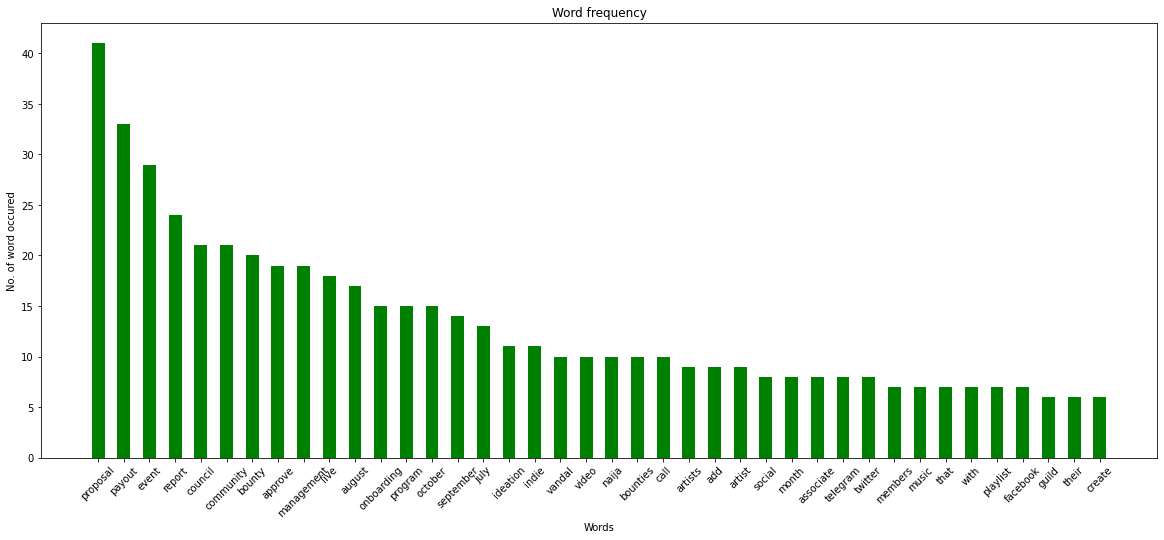

#### bounties.sputnikdao.near ####
Proposals: 8


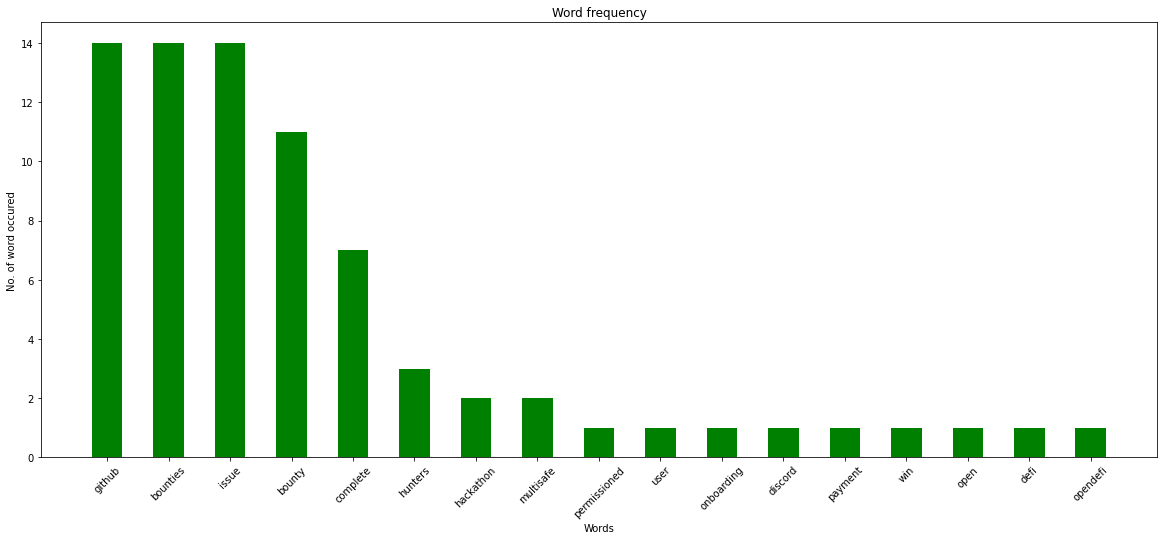

#### createbase.sputnikdao.near ####
Proposals: 491


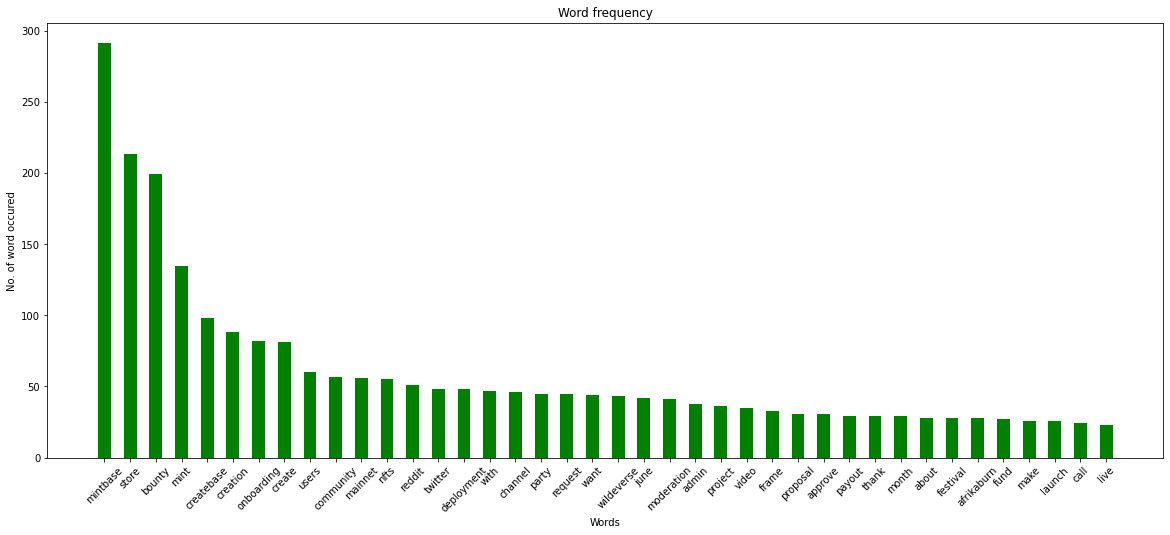

In [27]:
for dao in list(df1['dao'].unique()): 
    print(f"#### {dao} ####")
    print(f"Proposals: {len(df1['description'][df1['dao']==dao])}")
    plot_top_n_words(dao , 40)

# Investigation of Formal Funding Flow

We have to make chocies about the model: 
- Graphs ==> MultiDiGraph
    * Are the edges directed? Yes, a proposer can be target and vice versa 
    * Are multiple Edges allowed between each pair of nodes? Yes, propser can have multiple targets, repeat proposals 
   

    
- Nodes and Edges ==> Edges are weighted  
    * Do Edges carry information or not? Yes, they carry the amount of funding data
    
    
    
What are we investigating? 

We are primarily looking at two different Graphs: 
   * 1) Graph (G) looks at the relationship between DAOs and proposal targets.

   * 2) Graph (G2) looks at the relationship between proposal proposer and target. 


Open question: Is it interesting to visualise the DAO and the proposer of the target? 


In [28]:
import networkx as nx

#Step 1: filter if success 
d1_nx = df1[df1['status'] == 'Success']

#Step 2: Order by voting period end [highest number = newest]
d1_nx_s = d1_nx.sort_values(by = 'vote_period_end',  ascending=False)

#Step 3: set width of Graph by creating new coloumn and naming it width
d1_nx_s['width'] = np.log(d1_nx_s['amount (near)']+1) #take log to scale in

#Step 4: Build weighted tuples 
G = nx.from_pandas_edgelist(d1_nx_s,
                           source='dao', # This needs to be the DAO right - Community Squad, if yes need replacing with addresses
                           target='target',
                           edge_attr='width')

#Step 5: Build second graph
G2 = nx.from_pandas_edgelist(d1_nx_s,
                           source='proposer', # This needs to be the DAO right - Community Squad
                           target='target',
                           edge_attr='width')


In [29]:
#Step 6:Check the Visualisation - https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259

from pyvis.network import Network 

net = Network(notebook=True)

net.from_nx(G)


net.show("formal_funding_flow.html")

## Quantifing Network properties

As source for this analysis the folwoing resource was utilised: https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python.


To-Do: 
- Figure out why certain things don't work for G2 (e.g. Network largest component)
- Update interpreation for G2 

### Basic network Information

In [30]:
from operator import itemgetter

## general info
print(nx.info(G))
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 617
Number of edges: 704
Average degree:   2.2820
Name: 
Type: Graph
Number of nodes: 654
Number of edges: 693
Average degree:   2.1193


There are 654 Nodes (unqiue addresses) and 693 edges (connections) between them. The average degree (i.e. the number of nodes that it is connected to by an edge) is 2.28. 

### The Shape of the Network

#### Network density
- Def.: the ratio of actual edges in the network to all possible edges in the network
- Use: Provides a quick sense of how closely knit your network is
- The values range between 0 to 1 where a value of 1 indicates a denser network

In [31]:
## Network density 
## Def.: the ratio of actual edges in the network to all possible edges in the network
## Use: Provides a quick sense of how closely knit your network is
## 
density = nx.density(G)
print("Network density:", density)

density2 = nx.density(G2)
print("Network 2 density:", density2)

Network density: 0.0037045612410280156
Network 2 density: 0.003245430405889543


#### Network diameter
- Def.: diameter, which is the longest of all shortest paths. It calculates all shortest paths between every possible pair of nodes in the network, diameter is the length of the path between the two nodes that are furthest apart. 
- Use: The measure is designed to give you a sense of the network’s overall size, the distance from one end of the network to another.

In [32]:
# Step 1: If your Graph has more than one component, this will return False:
print(nx.is_connected(G))
print(nx.is_connected(G2))

# Step2:  use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:

### 1) Network G
components = nx.connected_components(G)
largest_component = max(components, key=len)

### 2) Newtork G2
components2 = nx.connected_components(G2)
largest_component2 = max(components2, key=len)


# Step 3: Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.

### 1) Network G
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

### 2) Network G2 - NOTE UNCLEAR WHY NOT WORKING --> Investigate 
# subgraph2 = G.subgraph(largest_component2)
# diameter2 = nx.diameter(subgraph2)
# print("Network diameter of largest component:", diameter2)

False
False
Network diameter of largest component: 9


The network diameter of this network’s largest component is 9: there is a path length of 9 between the two farthest-apart nodes in the network. Unlike density which is scaled from 0 to 1, it is difficult to know from this number alone whether 9 is a large or small diameter.

#### Triadic Closure
- If A and B transact with C. The A and B are likely to interact know each other too.
- Use: Identification of communities of nodes
- Calc.: One way of measuring triadic closure is called clustering coefficient because of this clustering tendency, but the structural network measure you will learn is known as transitivity.
- Def.: Transitivity is the ratio of all triangles over all possible triangles. 

In [33]:
## Network G1
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

## Network G2
triadic_closure2 = nx.transitivity(G2)
print("Triadic closure:", triadic_closure2)

Triadic closure: 0.0030435357946274975
Triadic closure: 0.01948051948051948


Transitivity is scaled from 0 to 1, and you can see that the network’s transitivity is about 0.00304, somewhat lower than its 0.003704 density.

### The Centrality of the Network

#### Degree 
- Def.: Sum of it Edges - e.g.  If a node has three lines extending from it to other nodes, its degree is three


In [34]:
# Network G1

## Step1: calculating degree  
degree_dict = dict(G.degree(G.nodes()))

## Step2: adding it as an attribute
nx.set_node_attributes(G, degree_dict, 'degree')

## Step3: sort dig
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

## Print result 
print("Top 25 nodes by degree:")
for d in sorted_degree[:25]:
    print(d)


Top 25 nodes by degree:
('createbase.sputnikdao.near', 201)
('sandbox.sputnikdao.near', 189)
('communitysquad.sputnikdao.near', 92)
('degens.sputnikdao.near', 50)
('humanguild.sputnikdao.near', 36)
('creatives.sputnikdao.near', 34)
('nxm-dao.sputnikdao.near', 32)
('marketing-vertical.sputnikdao.near', 29)
('knightsofgondor.sputnikdao.near', 16)
('genesis.sputnikdao.near', 14)
('assemblyscript.sputnikdao.near', 8)
('move.sputnikdao.near', 6)
('vandal.near', 4)
('alejandro.near', 4)
('bounties.sputnikdao.near', 4)
('rebecca.near', 4)
('tabear.near', 3)
('jiten1.near', 3)
('marmaj.sputnik-dao.near', 3)
('chloe.near', 3)
('slacker.near', 3)
('oiclid.near', 3)
('dedeukwu.near', 3)
('sanket.near', 3)
('zeitwarp.near', 3)


In [35]:
# Network G2

## Step1: calculating degree  
degree_dict2 = dict(G2.degree(G2.nodes()))

## Step2: adding it as an attribute
nx.set_node_attributes(G2, degree_dict2, 'degree')

## Step3: sort dig
sorted_degree2 = sorted(degree_dict2.items(), key=itemgetter(1), reverse=True)

## Print result 
print("Top 25 nodes by degree:")
for d in sorted_degree2[:25]:
    print(d)


Top 25 nodes by degree:
('carolin.near', 18)
('len.near', 15)
('vandal.near', 12)
('monikablockdiver.near', 12)
('chloe.near', 11)
('rebecca.near', 11)
('starpause.near', 10)
('chloethedev.near', 9)
('zeitwarp.near', 8)
('s4nts.near', 7)
('coyotefugly.near', 7)
('mariamneu.near', 6)
('tabear.near', 6)
('thegrace.near', 6)
('createbase.near', 6)
('createbase.sputnikdao.near', 5)
('frnvpr.near', 5)
('nearlove.near', 5)
('infinity.near', 5)
('iotha.near', 5)
('arrozcriativo.sputnikdao.near', 4)
('davidmo.near', 4)
('royal2021.near', 4)
('vrdoingthings.near', 4)
('cryptocredit.near', 4)


#### Eigenvector 
- Def.: . Eigenvector centrality is a kind of extension of degree—it looks at a combination of a node’s edges and the edges of that node’s neighbors. Eigenvector centrality cares if you are a hub, but it also cares how many hubs you are connected to. It’s calculated as a value from 0 to 1: the closer to one, the greater the centrality.
- Use: Eigenvector centrality is useful for understanding which nodes can get information to many other nodes quickly. 

In [36]:
# Network G1
eigenvector_dict = nx.eigenvector_centrality(G)

## Assign each to an attribute in your network
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

## sort eigenvector 
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

## print results
print("Top 25 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:25]:
    print(b)

Top 25 nodes by eigenvector centrality:
('createbase.sputnikdao.near', 0.6373138730324889)
('sandbox.sputnikdao.near', 0.28614095959498254)
('communitysquad.sputnikdao.near', 0.16368637595390953)
('creatives.sputnikdao.near', 0.09975705732736774)
('rebecca.near', 0.07877518833351159)
('oiclid.near', 0.06470077658402441)
('zeitwarp.near', 0.06470077658402441)
('vandal.near', 0.06319264190402926)
('slacker.near', 0.06314025825616622)
('monish016.near', 0.061290407920155304)
('psalm.near', 0.061290407920155304)
('guiltyangel.near', 0.061290407920155304)
('trendheo.near', 0.061290407920155304)
('rynprolol.near', 0.061290407920155304)
('nguyenhoanganhkhoa2321997.near', 0.061290407920155304)
('jilt.near', 0.061290407920155304)
('tabear.near', 0.059782273240160166)
('sanket.near', 0.05558161727831422)
('starpause.near', 0.0531615096760886)
('nft-onboarding.sputnikdao.near', 0.0531615096760886)
('dedeukwu.near', 0.052328625054744546)
('nxm-dao.sputnikdao.near', 0.05138492910801451)
('marmaj.sp

In [37]:
# Network G2 - Error

# eigenvector_dict2 = nx.eigenvector_centrality(G2)

# ## Assign each to an attribute in your network
# nx.set_node_attributes(G2, eigenvector_dict2, 'eigenvector')

# ## sort eigenvector 
# sorted_eigenvector2 = sorted(eigenvector_dict2.items(), key=itemgetter(1), reverse=True)

# ## print results
# print("Top 25 nodes by eigenvector centrality:")
# for b in sorted_eigenvector[:25]:
#     print(b)

#### Betweeness Centrality 
- Def.: Betweenness centrality looks at all the shortest paths that pass through a particular node (see above). Betweenness centrality, which is also expressed on a scale of 0 to 1
- Use: it is fairly good at finding nodes that connect two otherwise disparate parts of a network (i.e. Brokers)

In [38]:
# Network G1

betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality

## Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')

## sort betweenness
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)


## print results
print("Top 25 nodes by betweenness centrality:")
for b in sorted_betweenness[:25]:
    print(b)

Top 25 nodes by betweenness centrality:
('createbase.sputnikdao.near', 0.54035511370893)
('sandbox.sputnikdao.near', 0.46921205799013)
('communitysquad.sputnikdao.near', 0.2871719153098106)
('degens.sputnikdao.near', 0.10670615088040375)
('humanguild.sputnikdao.near', 0.09756881288018439)
('chloethedev.near', 0.06736353077816493)
('creatives.sputnikdao.near', 0.06704065720095156)
('genesis.sputnikdao.near', 0.06533101045296168)
('slacker.near', 0.05694391031805195)
('nxm-dao.sputnikdao.near', 0.050651088792018906)
('marketing-vertical.sputnikdao.near', 0.04591447568910799)
('knightsofgondor.sputnikdao.near', 0.03181819455327156)
('cryptocredit.near', 0.030142214654105038)
('alejandro.near', 0.02754894186238554)
('oiclid.near', 0.025244317931823537)
('zeitwarp.near', 0.025244317931823537)
('nearmax.near', 0.025087108013937282)
('rebecca.near', 0.024428025707960543)
('assemblyscript.sputnikdao.near', 0.022099039172209903)
('realorrin.near', 0.020538129605081654)
('swagger.near', 0.020538

In [39]:
# Network G2

betweenness_dict2 = nx.betweenness_centrality(G2) # Run betweenness centrality

## Assign each to an attribute in your network
nx.set_node_attributes(G2, betweenness_dict2, 'betweenness')

## sort betweenness
sorted_betweenness2 = sorted(betweenness_dict2.items(), key=itemgetter(1), reverse=True)


## print results
print("Top 25 nodes by betweenness centrality:")
for b in sorted_betweenness2[:25]:
    print(b)

Top 25 nodes by betweenness centrality:
('chloe.near', 0.01865633747744629)
('createbase.sputnikdao.near', 0.017729694495259758)
('vandal.near', 0.01504902875288731)
('chloethedev.near', 0.012641043226636846)
('rebecca.near', 0.009329958272545107)
('carolin.near', 0.009061528199250275)
('mariamneu.near', 0.008864232095378573)
('len.near', 0.007351628632362198)
('monikablockdiver.near', 0.007187215212469114)
('infinity.near', 0.006583079778759929)
('thegrace.near', 0.006579388865252127)
('creatives.sputnikdao.near', 0.006365819188186933)
('jcpacion.near', 0.006160302413320574)
('vr-dao.sputnikdao.near', 0.0060973891148920975)
('frnvpr.near', 0.005665216696887419)
('lisboa-node.sputnik-dao.near', 0.004011687445391257)
('createbase.near', 0.00379369985670308)
('norahhl.near', 0.0035954530629884584)
('zeitwarp.near', 0.0035325397645599825)
('tabear.near', 0.003504354606864025)
('joep.near', 0.0030416482680220612)
('aliens.near', 0.0029500465055101984)
('s4nts.near', 0.0023722507727430733)


### Community detection with modularity
- Goal: Identify the subgroups or communities within the larger social structure
- Calculates: Modularity is a measure of relative density in your network: a community (called a module or modularity class) has high density relative to other nodes within its module but low density with those outside. Modularity gives you an overall score of how fractious your network is, and that score can be used to partition the network and return the individual communities
- Note: very useful for sparse networks


To-do: 
- interpreation 
- Network G2

In [40]:
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)

In [41]:
## format result into dict to add to network
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

In [42]:
# First get a list of just the nodes in that class
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: createbase.sputnikdao.near | Eigenvector Centrality: 0.6373138730324889
Name: thephilosopher.near | Eigenvector Centrality: 0.042297492826803874
Name: aqualift22.near | Eigenvector Centrality: 0.042297492826803874
Name: tolga.near | Eigenvector Centrality: 0.042297492826803874
Name: kodandi.near | Eigenvector Centrality: 0.042297492826803874


#### For small network identify all communities

In [43]:
# for i,c in enumerate(communities): # Loop through the list of communities
#     if len(c) > 2: # Filter out modularity classes with 2 or fewer nodes
#         print('Class '+str(i)+':', list(c)) # Print out the classes and their members

### Exporting to Gephi

In [44]:
#nx.write_gexf(G, 'quaker_network.gexf')

## Visualising Formal Funding Flow between the 14 provided DAOs

### Network G1

#### Preparation

In [45]:
### identify council members
council_raw = list(df1.columns)[10:]
council = []

for m in council_raw:
    
    if ".near" in m:
        
        # split names
        k = m.split("_")
        
        #take council names
        council.append(k[-1])


In [46]:
### affiliation with a other dao means either being target of or having proposed too 
properties = dict(G.nodes())
for name in properties.keys():
    
    ## calculate proposed/ target value
    tval = d1_nx['amount (near)'][(d1_nx.target == name) & (d1_nx.status == 'Success')].sum()
    pval = d1_nx['amount (near)'][(d1_nx.proposer == name) & (d1_nx.status == 'Success')].sum()
    affiliation = [*(d1_nx['dao'][(d1_nx.target == name) | (d1_nx.proposer == name)]), *(d1_nx['dao'][(d1_nx.target == name) & (d1_nx.proposer == name)])]
    
    ##add to dict 
    properties[name]['target_val'] = tval 
    properties[name]['proposer_val'] = pval 
    properties[name]['total_val'] = tval + pval 

    properties[name]['no_affiliation'] = len(set(affiliation)) ### affiliation with a other dao means either being target of or having proposed too
    properties[name]['affiliation'] = list(set(affiliation)) ### associated with which DAOs - extention degrees
    properties[name]['council'] = name in council    

In [47]:
## fixing affilation of DAO's
for dao in df1['dao'].unique(): 
    
    properties[dao]['affiliation'] = [dao]
    properties[dao]['no_affiliation'] = 1

In [48]:
df_properties = pd.DataFrame.from_dict(properties, orient='index')

In [49]:
### fixing node attributes - affilation 

for node in df_properties[df_properties.no_affiliation == 0 ].index:
    
    # affiliation is at least 1 (i.e. DAO address = affilate with the DAO)
    df_properties.loc[node, 'affiliation'].append(node)
    
    ##replace no_affilation
    df_properties.loc[node, 'no_affiliation'] +=1

 


#### Adding Colouring

In [50]:
### fixing node attributes - colouring

# List of colours - Source: https://sashamaps.net/docs/resources/20-colors/
list_of_colors = ['#3cb44b', '#4363d8', '#f58231', '#46f0f0', '#fffac8',
                  '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', 
                  '#800000', '#808000', '#000075', '#808080', '#ffffff',
                  '#000000' ]


# Build dict with colouring and DAOs
dao_colour_dict = {}

for ind, dao in enumerate( df1['dao'].unique()): 
    
    dao_colour_dict[dao] = list_of_colors[ind]

dao_colour_dict

{'communitysquad.sputnikdao.near': '#3cb44b',
 'creatives.sputnikdao.near': '#4363d8',
 'grants.sputnikdao.near': '#f58231',
 'marketing-vertical.sputnikdao.near': '#46f0f0',
 'humanguild.sputnikdao.near': '#fffac8',
 'sandbox.sputnikdao.near': '#bcf60c',
 'knightsofgondor.sputnikdao.near': '#fabebe',
 'degens.sputnikdao.near': '#008080',
 'assemblyscript.sputnikdao.near': '#e6beff',
 'genesis.sputnikdao.near': '#9a6324',
 'move.sputnikdao.near': '#800000',
 'nxm-dao.sputnikdao.near': '#808000',
 'bounties.sputnikdao.near': '#000075',
 'createbase.sputnikdao.near': '#808080'}

In [51]:
## colouring based on number of DAO affiliations - more than 1 purple else unique colour of a DAO

df_properties['color'] = ''


for node in df_properties.index:
        
    
    if df_properties.loc[node, 'no_affiliation'] > 1:
        
        # nodes with multiple affilation are magenta 
        df_properties.loc[node, 'color'] = '#f032e6'
        
        #print(node, df_properties.loc[node, 'no_affiliation'], df_properties.loc[node, 'color'])
        
    else: 
        
        # identify dao 
        dao = df_properties.loc[node, 'affiliation'][0]
        
        #identify colour 
        colour = dao_colour_dict[dao]
        
        # assign colour 
        df_properties.loc[node, 'color'] = colour
        
        #print(node, df_properties.loc[node, 'no_affiliation'], df_properties.loc[node, 'color'])

In [52]:
# ## Marking of counci members in yellow '#ffe119' & Dao in Cyan '#42d4f4'

# df_properties['color'] = ''


# for node in df_properties.index:
        
    
#     if df_properties.loc[node, 'council'] == True :
        
#         # council members are yellow 
#         df_properties.loc[node, 'color'] = '#ffe119' 
        
    
# #     if ".sputnikdao." in node or ".sputnik-dao." in node:
        
# #         # dao nodes are cyan 
# #         df_properties.loc[node, 'color'] = '#42d4f4'
        

In [53]:
# add colour 
nx.set_node_attributes(G, dict( zip (df_properties.index, df_properties.color)), 'color')

#### Adding shapes 

In [54]:
df_properties['shape'] = 'dot'


for node in df_properties.index:
        
    # change shape if they are council members 
    if df_properties.loc[node, 'council'] == True :
        
        # nodes with in council are marked as upwards triangle  
        df_properties.loc[node, 'shape'] = 'star'
        
        #print(node, df_properties.loc[node, 'council'], df_properties.loc[node, 'shape'])
     
    # change shape if dao address 
    if ".sputnikdao." in node or ".sputnik-dao." in node:
        
        # identify dao and mark as diamond
        df_properties.loc[node, 'shape'] = 'square'
        
        #print(node, df_properties.loc[node, 'shape'])

# Additional things to consider [Change shape if borker or hub]





In [55]:
# add shape
nx.set_node_attributes(G, dict( zip (df_properties.index, df_properties['shape'])),'shape')

#### Add Title

In [56]:
# df_properties['title'] = ""
# for node in df_properties.index:
    
#     #insert degree: Degree: {df_properties.loc[node, 'degree']},
    
#     df_properties['title'] = f""" Eigenvector: {df_properties.loc[node, 'eigenvector']}, Betweenness: {df_properties.loc[node, 'betweenness']}, Modularity: {df_properties.loc[node, 'modularity']}, Target Value: {df_properties.loc[node, 'target_val']}, Proposer Value: {df_properties.loc[node, 'proposer_val']}, Affiliated DAOs: {df_properties.loc[node, 'affiliation']},  Council member: {df_properties.loc[node, 'council']} """

In [57]:
tile_aff = zip( (['affiliation']*len(df_properties['affiliation']) ), df_properties['affiliation'])

nx.set_node_attributes(G, dict( zip( df_properties.index, tile_aff) ), 'title')

#### Modify Size

In [58]:
## change size based on total value received  or degree
nx.set_node_attributes(G, np.log(df_properties['total_val']+ 10), 'size')

#### Add Edge attributes - Note: [No necessary set in beginning]

In [59]:
# edge_properties = {}

# for i in dict(G.edges()).keys():
    
#     #calc weight
#     weight = df1['amount (near)'][(df1['dao']==i[0]) &(df1['target']==i[1])].sum()
#     # add edge weight [amount in near]
#     edge_properties[i] = {'width': np.log10(weight+1)}
#     #edge_properties[i] = {'color': '#808080'}

In [60]:
# ### Add edges
# nx.set_edge_attributes(G, edge_properties) 

#### Convert to pyvis 

In [61]:
# Make new pyvis chart from nodes
g = Network(height='800px', width='100%',notebook=True,heading='Funding Flow of Proposal from 14 DAOs - Near Ecosystem')
g.from_nx(G)
#g.show_buttons(filter_=['physics'])
g.show('Network_G1.html')

## Visualising Proposer and Target

### Network G2

In [62]:
### affiliation with a other dao means either being target of or having proposed too 
properties2 = dict(G2.nodes())
for name in properties2.keys():
    
    ## calculate proposed/ target value
    tval = d1_nx['amount (near)'][(d1_nx.target == name) & (d1_nx.status == 'Success')].sum()
    pval = d1_nx['amount (near)'][(d1_nx.proposer == name) & (d1_nx.status == 'Success')].sum()
    affiliation = [*(d1_nx['dao'][(d1_nx.target == name) | (d1_nx.proposer == name)]), *(d1_nx['dao'][(d1_nx.target == name) & (d1_nx.proposer == name)])]
    
    ##add to dict 
    properties2[name]['target_val'] = tval 
    properties2[name]['proposer_val'] = pval 
    properties2[name]['total_val'] = tval + pval 

    properties2[name]['no_affiliation'] = len(set(affiliation)) ### affiliation with a other dao means either being target of or having proposed too
    properties2[name]['affiliation'] = list(set(affiliation)) ### associated with which DAOs - extention degrees
    properties2[name]['council'] = name in council    

In [63]:
df_properties2 = pd.DataFrame.from_dict(properties2, orient='index')

#### Adding Colouring

In [64]:
## colouring based on number of DAO affiliations - more than 1 purple else unique colour of a DAO

df_properties2['color'] = ''


for node in df_properties2.index:
        
    
    if df_properties2.loc[node, 'no_affiliation'] > 1:
        
        # nodes with multiple affilation are magenta 
        df_properties2.loc[node, 'color'] = '#f032e6'
        
        #print(node, df_properties.loc[node, 'no_affiliation'], df_properties.loc[node, 'color'])
        
    else: 
        
        # identify dao 
        dao = df_properties2.loc[node, 'affiliation'][0]
        
        #identify colour 
        colour = dao_colour_dict[dao]
        
        # assign colour 
        df_properties2.loc[node, 'color'] = colour
        
        #print(node, df_properties.loc[node, 'no_affiliation'], df_properties.loc[node, 'color'])

In [65]:
# ## Marking of counci members in yellow '#ffe119' & Dao in Cyan '#42d4f4'

# df_properties['color'] = ''


# for node in df_properties.index:
        
    
#     if df_properties.loc[node, 'council'] == True :
        
#         # council members are yellow 
#         df_properties.loc[node, 'color'] = '#ffe119' 
        
    
# #     if ".sputnikdao." in node or ".sputnik-dao." in node:
        
# #         # dao nodes are cyan 
# #         df_properties.loc[node, 'color'] = '#42d4f4'
        

In [66]:
# add colour 
nx.set_node_attributes(G2, dict( zip (df_properties2.index, df_properties2.color)), 'color')

#### Adding shapes 

In [67]:
df_properties2['shape'] = 'dot'


for node in df_properties2.index:
        
    # change shape if they are council members 
    if df_properties2.loc[node, 'council'] == True :
        
        # nodes with in council are marked as star  
        df_properties2.loc[node, 'shape'] = 'star'
        
        #print(node, df_properties.loc[node, 'council'], df_properties.loc[node, 'shape'])
     
    # change shape if dao address 
    if ".sputnikdao." in node or ".sputnik-dao." in node:
        
        # identify dao and mark as square
        df_properties2.loc[node, 'shape'] = 'square'
        
        #print(node, df_properties.loc[node, 'shape'])

# Additional things to consider [Change shape if borker or hub]





In [68]:
# add shape
nx.set_node_attributes(G2, dict( zip (df_properties2.index, df_properties2['shape'])),'shape')

#### Add Title

In [69]:
# df_properties['title'] = ""
# for node in df_properties.index:
    
#     #insert degree: Degree: {df_properties.loc[node, 'degree']},
    
#     df_properties['title'] = f""" Eigenvector: {df_properties.loc[node, 'eigenvector']}, Betweenness: {df_properties.loc[node, 'betweenness']}, Modularity: {df_properties.loc[node, 'modularity']}, Target Value: {df_properties.loc[node, 'target_val']}, Proposer Value: {df_properties.loc[node, 'proposer_val']}, Affiliated DAOs: {df_properties.loc[node, 'affiliation']},  Council member: {df_properties.loc[node, 'council']} """

In [70]:
tile_aff2 = zip( (['affiliation']*len(df_properties2['affiliation']) ), df_properties2['affiliation'])

nx.set_node_attributes(G2, dict( zip( df_properties2.index, tile_aff2) ), 'title')

#### Modify Size

In [71]:
## change size based on total value received  or degree
nx.set_node_attributes(G2, df_properties2['degree'], 'size')

#### Add Edge attributes - Note: [No necessary set in beginning]

In [72]:
# edge_properties = {}

# for i in dict(G.edges()).keys():
    
#     #calc weight
#     weight = df1['amount (near)'][(df1['dao']==i[0]) &(df1['target']==i[1])].sum()
#     # add edge weight [amount in near]
#     edge_properties[i] = {'width': np.log10(weight+1)}
#     #edge_properties[i] = {'color': '#808080'}

In [73]:
# ### Add edges
# nx.set_edge_attributes(G, edge_properties) 

#### Convert to pyvis 

In [74]:
# Make new pyvis chart from nodes
g2 = Network(height='800px', width='100%',notebook=True,heading='Proposal Target Flow from 14 DAOs - Near Ecosystem')
g2.from_nx(G2)
#g.show_buttons(filter_=['physics'])
g2.show('Network_G2.html')

# Deeper analysis of Network Properties and components

## Looking at Broker (connectors)

A broker is a node that connects two otherwise disparate parts of a network (i.e. Brokers). This can be individual and or DAOs. We defined a broker based on the Betweeness Centrality of the Network. Any address achieving a score is classified as a broker. 

The Betweenness centrality looks at all the shortest paths that pass through a particular node (see above). Betweenness centrality, which is also expressed on a scale of 0 to 1. It can be used to finding nodes that connect two otherwise disparate parts of a network (i.e. Brokers). 

Sources: 
* [1] https://www.sscnet.ucla.edu/soc/faculty/mcfarland/soc112/cent-ans.htm
* [2] https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python.
    

#### H1: Broker less likely to be  coucil member than the rest of the population
* Are facilators council members?
* Why? Broker are non council member, as a council member is more likely to commit to one communtiy

In [75]:
# note we do not have access to all council member only to the DAO provided 
df_properties[df_properties.no_affiliation == 0 ]

Empty DataFrame
Columns: [size, degree, eigenvector, betweenness, modularity, target_val, proposer_val, total_val, no_affiliation, affiliation, council, color, shape]
Index: []

In [76]:
## community brokers 

### No of brokers that are council members 
council_brokers = len(df_properties[(df_properties['betweenness'] > 0) & 
                                    (~df_properties.index.str.contains('sputnikdao')) &
                                    (df_properties.council == True) ])

# ### No of brokers (df['D']==True)
brokers = len(df_properties[(df_properties['betweenness'] > 0)
                            & (~df_properties.index.str.contains('sputnikdao')) ])

In [77]:
council_brokers/brokers

0.25

In [78]:
### Non-council members 
### No of brokers that are council members 
council_non_brokers = len(df_properties[(df_properties['betweenness'] == 0) & 
                                    (~df_properties.index.str.contains('sputnikdao')) &
                                    (df_properties.council == True) ])

# ### No of brokers (df['D']==True)
non_brokers = len(df_properties[(df_properties['betweenness'] == 0)
                            & (~df_properties.index.str.contains('sputnikdao')) ])

In [79]:
council_non_brokers/non_brokers

0.07370517928286853

Approximately 20 % of brokers are also council members compared to only 5% of non-brokers that are council members. Thus falsifying our hypothesis.  

#### H2: Community member classified as Brokers are more likely to be active in multiple communties than the rest of the population
* Why? Broker's by definition connect multiple communties thus they are   

In [80]:
df_properties['no_affiliation'][(df_properties['betweenness'] > 0) 
              & (~df_properties.index.str.contains('sputnikdao'))].mean()

2.4615384615384617

In [81]:
df_properties['no_affiliation'][(df_properties['betweenness'] == 0) 
              & (~df_properties.index.str.contains('sputnikdao'))].mean()

1.091633466135458

#### H3: Brokers are statisiticvally significantly correlated with the value distributed
* why? As Brokers connect diseparate part of the network and do this most likely for a reason and try to build bridges

In [82]:
fig = px.scatter(df_properties[(df_properties['betweenness'] > 0) 
              & (~df_properties.index.str.contains('sputnikdao'))],
                 x="betweenness",
                 y= 'proposer_val',
                 title='Betweenness Centrality vs. Value Proposed')
fig.show()

Answer: The Hypothesis is falsified. Brokers seem to follow a inverse relationship if any at all. This means the greater the degree of Betweenness Centrality, the lower the value they have been target of in an proposal. 

#### H4: Brokers are statisiticvally significantly negatively correlated with the value target
* why? As Brokers connect diseparate part of the network and do this most likely for a reason and try to build bridges

In [83]:
fig = px.scatter(df_properties[(df_properties['betweenness'] > 0) 
              & (~df_properties.index.str.contains('sputnikdao'))],
                 x="betweenness",
                 y= 'target_val',
                 title='Betweenness Centrality vs. Target Proposed')
fig.show()

##  Hub (facilitators) 

A hub is a node connected to many other nodes and connect to many other Hubs. To define a Hub we use the Eigenvector centrality. It looks at a combination of a node’s edges and the edges of that node’s neighbors. Eigenvector centrality cares if you are a hub, but it also cares how many hubs you are connected to. It’s calculated as a value from 0 to 1: the closer to one, the greater the centrality.

#### H4: Eigenvector centrality of nodes is statisiticvally significantly correlated with the most value received
* Why? Many connnection = alot of exposure = increased target 

#### H5: Hubs are most likely council member than the rest of the population.
* Hubs are the most popular in the community with many connection making ti likely to be elected as council member 


### Additional Hypothesis

#### H: Broker make community spanning proposals or inclusive proposals [answer later]
* What type of proposal do Brokers pose?
* Why? Brokers are facilataor that involve mutliple community member thus making it likely that he
    > Note: Investigation of proposal in closer detail - Torsten?
    
#### H: Proposal of top 20 most central nodes address large issues in the near ecosystem. [answer later]
* Large issues: as identified via interviews